**Eric Meinhardt / emeinhardt@ucsd.edu**

In [1]:
#Prints **all** console output, not just last item in cell 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import json

# Overview

This notebook documents the process of creating an n-gram model from the Switchboard corpus using `kenlm`.

# 2001 release

See 
 - https://www.isip.piconepress.com/projects/switchboard/ for a very short description of Switchboard-1, Release 2.
 - http://www1.icsi.berkeley.edu/Speech/stp/description.html and https://www.isip.piconepress.com/projects/switchboard/doc/transcription_guidelines/transcription_guidelines.pdf for more on phonetic transcriptions.

In [3]:
os.getcwd()

'/mnt/cube/home/AD/emeinhar/switchboard-lm'

In [4]:
repo_dir = '/mnt/cube/home/AD/emeinhar/switchboard-lm'

In [5]:
swbd_icsi_dir = "/mnt/truffle/corpora/switchboard_icsi_phone/trans/icsi"

In [6]:
os.chdir(swbd_icsi_dir)
os.listdir()

['AAREADME.text',
 'ms98_icsi_phone.text',
 'ms98_icsi_word.text',
 '.ms98_icsi_word.text.swp',
 '.AAREADME.text.swp',
 '.ms98_icsi_phone.text.swp',
 '.ms98_icsi_phone.text.swo']

In [7]:
%cat -n AAREADME.text | head -100

     1	This release contains a version of the ICSI phonetically-transcribed
     2	data that has been mapped onto the ISIP MS98 transcriptions.
     3	There are three files in this release:
     4	
     5	 AAREADME.text        => you're looking at it
     6	 ms98_icsi_word.text  => word transcriptions
     7	 ms98_icsi_phone.text => corresponding phone transcriptions
     8	
     9	In ms98_icsi_word.text, you will find entries of the form:
    10	
    11	 sw2039A-ms98-a-0086 377.245750 384.456750 uh "after the what" uh was it the King James Version when the committee
    12	
    13	The first entry is an MS98 utterance ID. The second and third entries are
    14	the start and stop times of the MS98 utterance. The next entry is the
    15	word transcription, following the MS98 conventions.
    16	
    17	*Most importantly*, the words in quotes represent those words for which
    18	there are ICSI phonetic transcriptions.
    19	
    20	In ms98_icsi_phone.text you will find entries of the

## Significance

 - This release of the data does NOT contain all utterances in Switchboard.
 - It just contains utterances where some subsequence has been phonetically transcribed.
 - Each utterance has exactly one contiguous subsequence that has been transcribed as a sequence of phones.
 - Each utterance has duration information.
 - Each transcribed subsequence has duration information (for the length of the whole subsequence).
 - A transcription is a sequence of phones (i.e. with no boundaries of any kind).
 - There are ≈40k transcribed wordforms in this release.

## Parse `word` files

In [8]:
%cat -n ms98_icsi_word.text | head -10

     1	sw2001B-ms98-a-0012 64.180625 71.048000 yes now you know if if "every[body]- like in August when everybody's on vacation or something we can dress a little more casual" or
     2	sw2005A-ms98-a-0020 173.970875 185.294250 yeah well my uh my "uh probably one of the biggest decisions i think that was very strengthened for our family [noise] was rather than have one child make that decision"
     3	sw2005A-ms98-a-0023 208.998750 221.283375 finding a place and everybody had duties to perform you know whether it was just you know giving money or whether it was actually taking part in in a lot of the decision making you know "like finding a a proper nursing home"
     4	sw2005A-ms98-a-0024 221.283375 235.435250 and they i know they and well they had well they had they had seen it coming so "so i mean [noise] it i mean i i i i har[dly]- i" i truly wish that if something like that were to happen that my children would do something like that for me
     5	sw2005A-ms98-a-0042 334.179125 34

In [9]:
icsi_lines = []
with open("ms98_icsi_word.text", 'r') as the_file:
    for line in the_file:
#         if line[0] != '#' and line.rstrip() != '':
        icsi_lines.append(line.rstrip())
len(icsi_lines)

5397

In [10]:
from collections import Counter

In [11]:
countDoubleQuotes = lambda s: Counter(s)['"']
countDoubleQuotes('fo"ob"ar')

2

In [12]:
Counter(list(map(countDoubleQuotes,
                 icsi_lines)))

Counter({2: 5397})

Every single line has exactly two doublequote characters in it.

In [13]:
from itertools import dropwhile, takewhile, chain, zip_longest

def extractFirstQuotedSubstring(s):
#     symbols = list(s)
    symbols = s
    
    unquotedPrefix = ''.join( tuple(takewhile(lambda x: x!= '"', symbols)) )
#     print('unquotedPrefix: {0}'.format(unquotedPrefix))
    
    unQuotedPrefixRemoved = ''.join(tuple(dropwhile(lambda x: x != '"', symbols)))
#     print('unQuotedPrefixRemoved: {0}'.format(unQuotedPrefixRemoved))
    justQuotedInfix = ''.join(tuple(takewhile(lambda x: x != '"', unQuotedPrefixRemoved[1:])))
#     print('justQuotedInfix: {0}'.format(justQuotedInfix))
    
    prefixPlusInfix = unquotedPrefix + '"' + justQuotedInfix + '"'
#     print('prefixPlusInfix: {0}'.format(prefixPlusInfix))
    alignment = tuple(zip_longest(symbols,
                                  prefixPlusInfix,
                                  fillvalue='_'))
#     print('alignment: {0}'.format(alignment))
    remainingSuffix = ''.join(map(lambda pair: pair[0],
                                  dropwhile(lambda pair: pair[1] != '_',
                                            alignment)))
#     print('remainingSuffix: {0}'.format(remainingSuffix))
#     return {'quoted':justQuotedInfix, 'remainder':remainingSuffix}
    return justQuotedInfix, remainingSuffix

def extractAllQuotedSubstrings(s, acc_quotes=None):
    if acc_quotes is None:
        acc_quotes = tuple()
        
    newQuotedInfix, newRemainingSuffix = extractFirstQuotedSubstring(s)
    
    if newQuotedInfix == '':
        return acc_quotes
    if s == '':
        return acc_quotes
#     acc_quotes.append(newQuotedInfix)
    return extractAllQuotedSubstrings(newRemainingSuffix, acc_quotes + (newQuotedInfix,))

def getQuoted(speech_raw):
#     return extractAllQuotedSubstrings(speech_raw)
    return (extractFirstQuotedSubstring(speech_raw)[0], )

extractFirstQuotedSubstring('abc "123" def')
extractFirstQuotedSubstring('abc 123 def')
extractFirstQuotedSubstring('"123" def')
extractFirstQuotedSubstring('"123"')
extractFirstQuotedSubstring('"123""456"')
' '
extractAllQuotedSubstrings('abc "123" def')
extractAllQuotedSubstrings('abc 123 def')
extractAllQuotedSubstrings('"123" def')
extractAllQuotedSubstrings('"123"')
extractAllQuotedSubstrings('abc "123""456" def')
extractAllQuotedSubstrings('abc "123" def "456"')
extractAllQuotedSubstrings('abc "123" def "456" "789"')
extractAllQuotedSubstrings('abc 123 def')
extractAllQuotedSubstrings('"123" def "456')
extractAllQuotedSubstrings('"123""456"')

('123', ' def')

('', '')

('123', ' def')

('123', '')

('123', '"456"')

' '

('123',)

()

('123',)

('123',)

('123', '456')

('123', '456')

('123', '456', '789')

()

('123', '456')

('123', '456')

In [14]:
# 'sw2001B-ms98-a-0012'
def parse_icsi_utterance_line(line):
    parts = line.split(' ')
#     return parts
    utterance_id = parts[0]
    
    start = float(parts[1])
    end = float(parts[2])
    duration = end - start
    
    if len(parts) > 3:
        speech_raw_words = parts[3:]
        speech_raw = ' '.join( speech_raw_words )
    else:
#         speech_raw_words = 
        speech_raw = ''
    
    if speech_raw == '':
        speech_noquotes = speech_raw
    else:
        speech_noquotes_words = speech_raw.split(' ')
        isDoubleQuote = lambda s: s == '"'
        removeDoubleQuotes = lambda w: ''.join([s for s in w if not isDoubleQuote(s)])
        speech_noquotes_words = list(map(removeDoubleQuotes, speech_noquotes_words))
#         print(speech_noquotes_words)
        speech_noquotes = ' '.join( speech_noquotes_words )
    
    if speech_raw == '':
        speech_quoted = ''
    else:
#         sp = speech_raw.split('"')
#         beginsWithQuote = [phrase for phrase in sp 
#                            if len(phrase) > 0 and phrase[0] == '"']
#         endsWithQuote = [phrase for phrase in sp 
#                          if len(phrase) > 0 and phrase[-1] == '"']
#         beginsAndEndsWithQuote = [phrase for phrase in sp 
#                                   if len(phrase) > 0 and phrase[0] == '"' and phrase[-1] == '"']
#         assert len(beginsWithQuote) == len(endsWithQuote), 'Compare:\n\t{0}\n vs.\n\t{1}\n in\n\t{2}'.format(beginsWithQuote, endsWithQuote, speech_raw_words)
#         assert len(beginsAndEndsWithQuote) == len(beginsWithQuote), 'Compare:\n\t{0}\n vs.\n\t{1}\n vs.\n\t{2} in\n\t{3}'.format(beginsWithQuote, endsWithQuote, beginsAndEndsWithQuote, speech_raw_words)
        
#         quoted = beginsAndEndsWithQuote
        quoted = getQuoted(speech_raw)
        assert len(quoted) == 0 or len(quoted) == 1, 'len(quoted) = {0}'.format(len(quoted))
        if len(quoted) == 0:
            speech_quoted = ''
        else:
            speech_quoted = quoted[0]
    
    line_rel = {'utterance_id':utterance_id,
                'start':start,
                'end':end,
                'duration':duration,
                'speech_raw':speech_raw,
                'speech_quoted':speech_quoted
#                 'speech_noquotes':speech_noquotes
               }
    
    return line_rel

In [15]:
icsi_utterance_relations = list(map(parse_icsi_utterance_line, icsi_lines))
l = icsi_utterance_relations[0]
l

{'utterance_id': 'sw2001B-ms98-a-0012',
 'start': 64.180625,
 'end': 71.048,
 'duration': 6.867374999999996,
 'speech_raw': 'yes now you know if if "every[body]- like in August when everybody\'s on vacation or something we can dress a little more casual" or',
 'speech_quoted': "every[body]- like in August when everybody's on vacation or something we can dress a little more casual"}

## What and how many orthographic wordforms have been transcribed in this dataset?

About how many orthographic wordforms are transcribed (= within quoted speech)?

In [16]:
def get_transcribed_wordform_tokens_icsi(parsed_icsi_utterance_rel):
    r = parsed_icsi_utterance_rel
    tokens = r['speech_quoted'].split(' ')
    return tuple(tokens)

def approxWordformTokenCount_icsi(parsed_icsi_utterance_rel):
    r = parsed_icsi_utterance_rel
    c = len(get_transcribed_wordform_tokens_icsi(r))
    return c

In [17]:
from itertools import chain

In [18]:
orthographic_wordform_tokens_icsi = tuple(chain.from_iterable(map(get_transcribed_wordform_tokens_icsi, 
                                                                  icsi_utterance_relations)))
len(orthographic_wordform_tokens_icsi)
orthographic_unigram_counts_icsi = Counter(orthographic_wordform_tokens_icsi)
orthographic_unigram_counts_icsi.most_common()

42219

[('i', 1617),
 ('and', 1495),
 ('the', 1328),
 ('uh', 1145),
 ('you', 992),
 ('that', 990),
 ('a', 962),
 ('to', 882),
 ('of', 724),
 ('it', 685),
 ('know', 606),
 ('in', 551),
 ('yeah', 519),
 ('they', 464),
 ("it's", 435),
 ('have', 421),
 ('we', 397),
 ('is', 394),
 ('so', 393),
 ('but', 379),
 ('um', 361),
 ('like', 331),
 ('was', 328),
 ('well', 302),
 ('do', 287),
 ("that's", 278),
 ('just', 274),
 ('for', 263),
 ("don't", 261),
 ('on', 260),
 ('think', 258),
 ('oh', 249),
 ('really', 229),
 ('what', 227),
 ('or', 222),
 ('right', 218),
 ('not', 216),
 ('are', 202),
 ('with', 199),
 ('my', 187),
 ("i'm", 178),
 ('all', 172),
 ('there', 172),
 ('at', 172),
 ('one', 168),
 ('about', 165),
 ('be', 160),
 ('had', 154),
 ('if', 154),
 ('as', 147),
 ('out', 144),
 ('no', 142),
 ('then', 142),
 ('get', 142),
 ('now', 134),
 ('when', 130),
 ('some', 123),
 ('up', 120),
 ('go', 117),
 ('can', 115),
 ('because', 114),
 ('this', 112),
 ("they're", 107),
 ('lot', 107),
 ('people', 106),
 ("i

≈42k orthographic wordform tokens have been transcribed.

In [19]:
from functools import reduce

union = lambda Ss: reduce(set.union, Ss)

In [20]:
orthographic_vocabulary_icsi = union(map(lambda r: set(get_transcribed_wordform_tokens_icsi(r)),
                                    icsi_utterance_relations))
len(orthographic_vocabulary_icsi)
orthographic_vocabulary_icsi

4499

{"shouldn't",
 'heated',
 'supplement',
 'downtime',
 'snakes',
 'knowledgeable',
 'purchased',
 'picked',
 'digestive',
 'Show',
 'southern',
 'th[ree]-',
 'overtones',
 'put',
 "[laughter-i've]",
 'combined',
 'hold',
 'players',
 'illegally',
 'Le[land]-',
 'techniques',
 'structured',
 'factors',
 'friend',
 'cone',
 'building',
 'aerobics',
 'murdered',
 'breeders',
 'be',
 'assistance',
 'lasted',
 "mom's",
 'method',
 'lawyers',
 'time',
 'funding',
 'plenty',
 'come',
 'woodworking',
 'sausage',
 'th[at]-',
 'wind',
 'remote',
 'Asia',
 'smarter',
 'Saudi',
 "that'll",
 'exempt',
 'catty-cornered',
 'related',
 'emergency',
 'terrible',
 'lists',
 'chore',
 'chips',
 'shovel',
 "child's",
 'served',
 'cracking',
 'wait',
 'novels',
 'part',
 'Woodland',
 'manufacturer',
 'back',
 'feature',
 'daughter',
 '[laughter-know]',
 'offenses',
 'h[ave]-',
 '[laughter-of]',
 'site',
 'collections',
 'wrong',
 'access',
 'burners',
 'Pete',
 'homemade',
 "there'd",
 'product',
 'Heart',


≈4.5k orthographic wordform types have been transcribed.

In [21]:
hasSquareBrackets = lambda w: "[" in w or "]" in w
bracketed_orthographic_words_icsi = set(filter(hasSquareBrackets,
                                          orthographic_vocabulary_icsi))
len(bracketed_orthographic_words_icsi)
bracketed_orthographic_words_icsi

304

{"-[De]troit's",
 '-[a]nother',
 '-[i]t',
 "-[it']s",
 '-[re]quires',
 '-[un]til',
 '-[w]ell',
 'Ber[muda]-',
 'Bo[hemian]-',
 'Expre[ss]-',
 'Le[land]-',
 'Phil[ip]-',
 'Ply[mouth]-',
 'Sat[urday]-',
 'Sea[gull]-',
 'Te[xas]-',
 'Tex[as]-',
 '[annuitity/annuity]',
 '[ar[f]-/off]',
 '[assumingly/assumably]',
 '[civinal/civil]',
 '[laughter-Avon]',
 '[laughter-God]',
 '[laughter-a]',
 '[laughter-about]',
 '[laughter-all]',
 '[laughter-am]',
 '[laughter-and]',
 '[laughter-around]',
 '[laughter-bait]',
 '[laughter-basis]',
 '[laughter-books]',
 '[laughter-boy]',
 '[laughter-but]',
 '[laughter-closely]',
 '[laughter-day]',
 '[laughter-enough]',
 '[laughter-ever]',
 '[laughter-every]',
 '[laughter-everybody]',
 '[laughter-experience]',
 '[laughter-for]',
 '[laughter-get]',
 '[laughter-goes]',
 '[laughter-gone]',
 '[laughter-good]',
 '[laughter-got]',
 '[laughter-guns]',
 '[laughter-heard]',
 "[laughter-i'm]",
 "[laughter-i've]",
 '[laughter-i]',
 '[laughter-in]',
 '[laughter-incredibly]',
 

≈304 of those types involve brackets and plausibly require further pre or post-processing.

## How many conversations are data taken from?

In [ ]:
'sw2001B-ms98-a-0012'

In [106]:
def extract_conversation_id(utterance_id):
    return utterance_id[2:6]
extract_conversation_id('sw2001B-ms98-a-0012')

'2001'

In [109]:
icsi_conversation_ids_list = list(map(lambda rel: extract_conversation_id(rel['utterance_id']),
                                      icsi_utterance_relations))
len(set(icsi_conversation_ids_list))
Counter(icsi_conversation_ids_list).most_common()

1629

[('2830', 100),
 ('2887', 80),
 ('2547', 15),
 ('2780', 15),
 ('2661', 14),
 ('2145', 13),
 ('2005', 12),
 ('2482', 12),
 ('2776', 12),
 ('2969', 12),
 ('2019', 11),
 ('2040', 11),
 ('2051', 11),
 ('2334', 11),
 ('2362', 11),
 ('2938', 11),
 ('2953', 11),
 ('2020', 10),
 ('2028', 10),
 ('2065', 10),
 ('2085', 10),
 ('2157', 10),
 ('2426', 10),
 ('2499', 10),
 ('2534', 10),
 ('2755', 10),
 ('2766', 10),
 ('2851', 10),
 ('2909', 10),
 ('3115', 10),
 ('2064', 9),
 ('2086', 9),
 ('2154', 9),
 ('2260', 9),
 ('2353', 9),
 ('2389', 9),
 ('2427', 9),
 ('2451', 9),
 ('2460', 9),
 ('2467', 9),
 ('2472', 9),
 ('2506', 9),
 ('2584', 9),
 ('2586', 9),
 ('2603', 9),
 ('2610', 9),
 ('2623', 9),
 ('2711', 9),
 ('2723', 9),
 ('2772', 9),
 ('2793', 9),
 ('2847', 9),
 ('2877', 9),
 ('2941', 9),
 ('2959', 9),
 ('3028', 9),
 ('3111', 9),
 ('3658', 9),
 ('4026', 9),
 ('4171', 9),
 ('4372', 9),
 ('4483', 9),
 ('4617', 9),
 ('4707', 9),
 ('4940', 9),
 ('2039', 8),
 ('2181', 8),
 ('2197', 8),
 ('2237', 8),
 ('

Utterances are from 1629 distinct conversations.

## Parsing the `phones` files

In [22]:
%pwd

'/mnt/truffle/corpora/switchboard_icsi_phone/trans/icsi'

In [23]:
%ls

AAREADME.text*  ms98_icsi_phone.text*  ms98_icsi_word.text*


In [24]:
%cat -n ms98_icsi_phone.text | head -10

     1	sw2001B-ms98-a-0012 66.168250 70.294998 eh v r iy l ay k ih n ao g ix s w eh n eh r_co_! r_! iy b aa d iy z_vl aa n v ey k ey sh ih_vl n er s ah m th ih ng k_epi w iy k ix n d r eh s el l el m ao r k ae zh w ax l h#
     2	sw2005A-ms98-a-0020 176.845000 185.135000 sil h# sil pv p r aa b l uw w ah_n ah v dh ix b ih g ix ? d ih s ih zh_vl ih n z_vl h# q ay th ih ng k dh ih w_cr_co w_cr uh z_vl sil v eh r iy s t r eh ng k th ax n d f aa r f ae m l ax w_co w ah z_vl h# r ae dh ix dh eh n hh ae v w ah n ch ay l_cr m ey k dh ae_cr d ix s ih zh_vl ih n h#
     3	sw2005A-ms98-a-0023 218.695000 221.165000 h# l ay_cr k f ay n ih_n ng ax_cr ax p r aa p er n er s ih_n ng hh ow_cr m h#
     4	sw2005A-ms98-a-0024 227.255000 230.725000 h# s ow w_on iy q aa m iy nx ih ih_cr t_vd h# aa m iy nx ay ay h# ay q aa hh eh_fr hh aa r q ay h# 
     5	sw2005A-ms98-a-0042 334.225000 335.515000 h# ih t w ah z ih n t h#
     6	sw2005A-ms98-a-0052 390.955000 394.545000 h# w iy h# w iy d ow n t h# w iy h# w i

There are
 - no word boundaries

...and therefore aren't really any word transcriptions directly available from this data (or word durations or phone durations).

# 2003 release

See https://www.isip.piconepress.com/projects/switchboard/.

In [25]:
swbd2003_dir = "/mnt/truffle/corpora/switchboard_word_alignments/swb_ms98_transcriptions"

In [41]:
%ls

20/  23/  26/  29/  32/  35/  38/  41/  44/  47/  AAREADME.text*
21/  24/  27/  30/  33/  36/  39/  42/  45/  48/  sw-ms98-dict.text*
22/  25/  28/  31/  34/  37/  40/  43/  46/  49/


In [29]:
%cat -n AAREADME.text | head -100

     1	This release contains manually corrected word alignments and transcriptions,
     2	and an updated dictionary.  
     3	
     4	Word alignments were generated by using the most recent release of the
     5	transcriptions and performing forced alignments using ISIP's Hub 5E
     6	recognition system (which is also publicly available). These
     7	alignments were manually reviewed for accurate discrimination
     8	between speech and non-speech.
     9	
    10	The released data is available at:
    11	
    12	 http://www.isip.msstate.edu/projects/switchboard/releases/switchboard_word_alignments.tar.gz
    13	
    14	As always, let us know if you have any questions. 
    15	
    16	Files contained in this release:
    17	
    18	2001
    19	 sw2001A-ms98-a-trans.text
    20	 sw2001A-ms98-a-word.text
    21	 sw2001B-ms98-a-trans.text
    22	 sw2001B-ms98-a-word.text
    23	2005
    24	 sw2005A-ms98-a-trans.text
    25	 sw2005A-ms98-a-word.text
    26	 sw2005B-ms98-a-trans.text
    

What information is in this release?

In [27]:
from itertools import filterfalse

In [33]:
os.chdir(swbd2003_dir)
os.listdir()
swbd2003_folders = list(filterfalse(lambda s: s[-5:] == '.text', os.listdir()))
swbd2003_folders

['20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 'AAREADME.text',
 'sw-ms98-dict.text']

['20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49']

In [36]:
%ls 20

2001/  2010/  2018/  2025/  2038/  2050/  2057/  2067/  2080/  2089/  2095/
2005/  2012/  2019/  2027/  2039/  2051/  2060/  2071/  2082/  2090/  2096/
2006/  2013/  2020/  2028/  2040/  2053/  2061/  2072/  2083/  2091/
2007/  2014/  2022/  2032/  2041/  2054/  2062/  2073/  2085/  2092/
2008/  2015/  2023/  2035/  2044/  2055/  2064/  2078/  2086/  2093/
2009/  2017/  2024/  2036/  2045/  2056/  2065/  2079/  2087/  2094/


In [37]:
%ls 20/2001

sw2001A-ms98-a-trans.text*  sw2001B-ms98-a-trans.text*
sw2001A-ms98-a-word.text*   sw2001B-ms98-a-word.text*


In [40]:
# swbd2003_files = []
conversation_ids = []
for folder in swbd2003_folders:
    os.chdir(folder)
    conversation_ids.extend(os.listdir())
    os.chdir('..')
len(conversation_ids)
conversation_ids[:30]

2438

['2001',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2012',
 '2013',
 '2014',
 '2015',
 '2017',
 '2018',
 '2019',
 '2020',
 '2022',
 '2023',
 '2024',
 '2025',
 '2027',
 '2028',
 '2032',
 '2035',
 '2036',
 '2038',
 '2039',
 '2040',
 '2041',
 '2044',
 '2045']

In [34]:
%cat -n ./20/2001/sw2001A-ms98-a-trans.text | head -50

     1	sw2001A-ms98-a-0001 0.000000 0.977625 [silence]
     2	sw2001A-ms98-a-0002 0.977625 11.561375 hi um yeah i'd like to talk about how you dress for work and and um what do you normally what type of outfit do you normally have to wear
     3	sw2001A-ms98-a-0003 11.561375 19.804875 [silence]
     4	sw2001A-ms98-a-0004 19.804875 21.312375 um-hum
     5	sw2001A-ms98-a-0005 21.312375 27.362000 [silence]
     6	sw2001A-ms98-a-0006 27.362000 28.932750 and is
     7	sw2001A-ms98-a-0007 28.932750 33.898250 [silence]
     8	sw2001A-ms98-a-0008 33.898250 40.123250 right right is there is there um an[y]- is there a like a code of dress where you work do they ask
     9	sw2001A-ms98-a-0009 40.123250 41.552625 right
    10	sw2001A-ms98-a-0010 41.552625 50.129500 [silence]
    11	sw2001A-ms98-a-0011 50.129500 51.567500 [noise] right
    12	sw2001A-ms98-a-0012 51.567500 56.957000 [silence]
    13	sw2001A-ms98-a-0013 56.957000 65.593625 right right and does it does it change i guess um you can can

In [35]:
%cat -n ./20/2001/sw2001A-ms98-a-word.text | head -100

     1	sw2001A-ms98-a-0001 0.000000 0.977625 [silence]
     2	sw2001A-ms98-a-0002 0.977625 1.215250 [silence]
     3	sw2001A-ms98-a-0002 1.215250 1.724625 hi
     4	sw2001A-ms98-a-0002 1.724625 2.273625 [silence]
     5	sw2001A-ms98-a-0002 2.273625 2.927625 um
     6	sw2001A-ms98-a-0002 2.927625 3.221500 [silence]
     7	sw2001A-ms98-a-0002 3.221500 3.661750 yeah
     8	sw2001A-ms98-a-0002 3.661750 3.957625 i'd
     9	sw2001A-ms98-a-0002 3.957625 4.107625 like
    10	sw2001A-ms98-a-0002 4.107625 4.267625 to
    11	sw2001A-ms98-a-0002 4.267625 4.527625 talk
    12	sw2001A-ms98-a-0002 4.527625 4.941625 about
    13	sw2001A-ms98-a-0002 4.941625 5.126125 [silence]
    14	sw2001A-ms98-a-0002 5.126125 5.307625 how
    15	sw2001A-ms98-a-0002 5.307625 5.437625 you
    16	sw2001A-ms98-a-0002 5.437625 5.735375 dress
    17	sw2001A-ms98-a-0002 5.735375 5.901125 [silence]
    18	sw2001A-ms98-a-0002 5.901125 6.077625 for
    19	sw2001A-ms98-a-0002 6.077625 6.477625 work
    20	sw2001A-ms98-a-0002 6

For each of ≈2400 conversations, there is 
 - a sequence of utterances for speaker A.
 - a sequence of utterances for speaker B.
 - a sequence of orthographic wordforms (and non-speech events) for speaker A.
 - a sequence of orthographic wordforms (and non-speech events) for speaker B.
 
For each utterance, there is a start and end time.

For each orthographic wordform or non-speech event, there is a duration.

## Retrieving files from conversation ids

In [43]:
swbd2003_dir

'/mnt/truffle/corpora/switchboard_word_alignments/swb_ms98_transcriptions'

In [44]:
%ls

20/  23/  26/  29/  32/  35/  38/  41/  44/  47/  AAREADME.text*
21/  24/  27/  30/  33/  36/  39/  42/  45/  48/  sw-ms98-dict.text*
22/  25/  28/  31/  34/  37/  40/  43/  46/  49/


In [47]:
%ls 20/2001

sw2001A-ms98-a-trans.text*  sw2001B-ms98-a-trans.text*
sw2001A-ms98-a-word.text*   sw2001B-ms98-a-word.text*


In [53]:
conversation_ids = set(conversation_ids)

In [56]:
def getDir(conversation_id):
    assert conversation_id in conversation_ids, '{0} is not a conversation id'.format(conversation_id)
    firstTwoDigits = conversation_id[:2]
    return os.path.join(swbd2003_dir, firstTwoDigits + '/' + conversation_id)

def getFilenames(conversation_id):
    assert conversation_id in conversation_ids, '{0} is not a conversation id'.format(conversation_id)
    return os.listdir(getDir(conversation_id))

getDir('2045')
getFilenames('2045')

'/mnt/truffle/corpora/switchboard_word_alignments/swb_ms98_transcriptions/20/2045'

['sw2045A-ms98-a-trans.text',
 'sw2045A-ms98-a-word.text',
 'sw2045B-ms98-a-trans.text',
 'sw2045B-ms98-a-word.text']

In [60]:
def getUtteranceFP(conversation_id, speaker):
    fp_prefix = getDir(conversation_id)
    
    assert speaker in {'A', 'B'}, 'Speaker must be either "A" or "B", got {0}'.format(speaker)
    
    fn_prefix = 'sw'
    fn_suffix = '-ms98-a-trans.text'
    fn = fn_prefix + conversation_id + speaker + fn_suffix
    assert fn in set(getFilenames(conversation_id))
    
    return os.path.join(fp_prefix, fn)

def getWordFP(conversation_id, speaker):
    fp_prefix = getDir(conversation_id)
    
    assert speaker in {'A', 'B'}, 'Speaker must be either "A" or "B", got {0}'.format(speaker)
    
    fn_prefix = 'sw'
    fn_suffix = '-ms98-a-word.text'
    fn = fn_prefix + conversation_id + speaker + fn_suffix
    assert fn in set(getFilenames(conversation_id))
    
    return os.path.join(fp_prefix, fn)

getUtteranceFP('2045','A')
getWordFP('2045','A')

'/mnt/truffle/corpora/switchboard_word_alignments/swb_ms98_transcriptions/20/2045/sw2045A-ms98-a-trans.text'

'/mnt/truffle/corpora/switchboard_word_alignments/swb_ms98_transcriptions/20/2045/sw2045A-ms98-a-word.text'

In [59]:
%cat -n /mnt/truffle/corpora/switchboard_word_alignments/swb_ms98_transcriptions/20/2045/sw2045A-ms98-a-trans.text | head -10

     1	sw2045A-ms98-a-0001 0.000000 1.411625 all right
     2	sw2045A-ms98-a-0002 1.411625 3.668625 i play volleyball and
     3	sw2045A-ms98-a-0003 3.668625 6.593875 softball and ceramics
     4	sw2045A-ms98-a-0004 6.593875 19.817125 [silence]
     5	sw2045A-ms98-a-0005 19.817125 21.945500 i didn't think of working out as a hobby
     6	sw2045A-ms98-a-0006 21.945500 22.259750 [laughter]
     7	sw2045A-ms98-a-0007 22.259750 25.479625 or playing with the computer i do both at home
     8	sw2045A-ms98-a-0008 25.479625 35.911625 [silence]
     9	sw2045A-ms98-a-0009 35.911625 43.178125 uh we've gotten a little Atari computer uh husband describes it as a a computer with training wheels
    10	sw2045A-ms98-a-0010 43.178125 44.533500 uh


## Parsing the utterance files

In [161]:
def parse_swbd_utterance_line(line):
    parts = line.split(' ')
#     return parts
    utterance_id = parts[0]
    
    start = float(parts[1])
    end = float(parts[2])
    duration = end - start
    
    if len(parts) > 3:
        speech_raw_words = parts[3:]
        speech_raw = ' '.join( speech_raw_words )
    else:
#         speech_raw_words = 
        speech_raw = ''
    
    if speech_raw == '':
        speech_OnlyWords = ''
        has_word_internal_brackets = False
    else:
        speech_wordforms = speech_raw.split(' ')
        speech_wordforms = [w for w in speech_wordforms if len(w) > 0 and w[0] != '[' and w[-1] != ']']
        speech_OnlyWords = ' '.join(speech_wordforms)
        hasBrackets = lambda w: "[" in w or "]" in w
        has_word_internal_brackets = True if any(list(map(hasBrackets, speech_wordforms))) else False
#         if any(list(map(hasBrackets, speech_wordforms))):
#             raise Exception("Word-internal brackets found in\n\t{0}".format(speech_OnlyWords))
    
    has_words = False if len(speech_raw) == 0 or (speech_raw[0] == '[' and speech_raw[-1] == ']') else True
    
    line_rel = {'utterance_id':utterance_id,
                'conversation_id':utterance_id[2:6],
                'speaker':utterance_id[6:7],
                'start':start,
                'end':end,
                'duration':duration,
                'speech_raw':speech_raw,
                'speech_words':speech_OnlyWords,
                'n_words':len(speech_OnlyWords.split(' ')),
                'has_words':has_words,
                'has_word_internal_brackets':has_word_internal_brackets
#                 'speech_noquotes':speech_noquotes
               }
    
    return line_rel

In [162]:
def read_swbd_file(swbd_fp):
    lines = []
    with open(swbd_fp, 'r') as the_file:
        for line in the_file:
            lines.append(line.rstrip())
    return lines

def get_utterance_relations(conversation_id, speaker):
    utterance_fp = getUtteranceFP(conversation_id, speaker)
    file_lines = read_swbd_file(utterance_fp)
    parsed_rel = tuple([parse_swbd_utterance_line(l) for l in file_lines])
    return parsed_rel

In [163]:
utts_2045A = get_utterance_relations('2045', 'A')
utts_2045A[:10]

({'utterance_id': 'sw2045A-ms98-a-0001',
  'conversation_id': '2045',
  'speaker': 'A',
  'start': 0.0,
  'end': 1.411625,
  'duration': 1.411625,
  'speech_raw': 'all right',
  'speech_words': 'all right',
  'n_words': 2,
  'has_words': True,
  'has_word_internal_brackets': False},
 {'utterance_id': 'sw2045A-ms98-a-0002',
  'conversation_id': '2045',
  'speaker': 'A',
  'start': 1.411625,
  'end': 3.668625,
  'duration': 2.257,
  'speech_raw': 'i play volleyball and',
  'speech_words': 'i play volleyball and',
  'n_words': 4,
  'has_words': True,
  'has_word_internal_brackets': False},
 {'utterance_id': 'sw2045A-ms98-a-0003',
  'conversation_id': '2045',
  'speaker': 'A',
  'start': 3.668625,
  'end': 6.593875,
  'duration': 2.9252499999999997,
  'speech_raw': 'softball and ceramics',
  'speech_words': 'softball and ceramics',
  'n_words': 3,
  'has_words': True,
  'has_word_internal_brackets': False},
 {'utterance_id': 'sw2045A-ms98-a-0004',
  'conversation_id': '2045',
  'speaker': 

## Parsing the word files

In [164]:
%cat -n ./20/2001/sw2001A-ms98-a-word.text | head -10

cat: ./20/2001/sw2001A-ms98-a-word.text: No such file or directory


In [165]:
def parse_swbd_word_line(line):
    parts = line.split(' ')
#     return parts
    utterance_id = parts[0]
    
    start = float(parts[1])
    end = float(parts[2])
    duration = end - start
    
    if len(parts) > 3:
        speech_raw_words = parts[3:]
        speech_raw = ' '.join( speech_raw_words )
    else:
#         speech_raw_words = 
        speech_raw = ''
    
    if speech_raw == '':
        speech_OnlyWords = ''
        has_word_internal_brackets = False
    else:
        speech_wordforms = speech_raw.split(' ')
        speech_wordforms = [w for w in speech_wordforms if len(w) > 0 and w[0] != '[' and w[-1] != ']']
        speech_OnlyWords = ' '.join(speech_wordforms)
        hasBrackets = lambda w: "[" in w or "]" in w
        has_word_internal_brackets = True if any(list(map(hasBrackets, speech_wordforms))) else False
#         if any(list(map(hasBrackets, speech_wordforms))):
#             raise Exception("Word-internal brackets found in\n\t{0}".format(speech_OnlyWords))
    
    has_words = False if len(speech_raw) == 0 or (speech_raw[0] == '[' and speech_raw[-1] == ']') else True
    
    line_rel = {'utterance_id':utterance_id,
                'conversation_id':utterance_id[2:6],
                'speaker':utterance_id[6:7],
                'start':start,
                'end':end,
                'duration':duration,
                'speech_raw':speech_raw,
                'speech_words':speech_OnlyWords,
                'has_words':has_words,
                'has_word_internal_brackets':has_word_internal_brackets
#                 'speech_noquotes':speech_noquotes
               }
    
    return line_rel

In [166]:
def get_word_relations(conversation_id, speaker):
    word_fp = getWordFP(conversation_id, speaker)
    file_lines = read_swbd_file(word_fp)
    parsed_rel = tuple([parse_swbd_word_line(l) for l in file_lines])
    return parsed_rel

In [167]:
words_2045A = get_word_relations('2045', 'A')
words_2045A[:10]

({'utterance_id': 'sw2045A-ms98-a-0001',
  'conversation_id': '2045',
  'speaker': 'A',
  'start': 0.0,
  'end': 0.47125,
  'duration': 0.47125,
  'speech_raw': '[silence]',
  'speech_words': '',
  'has_words': False,
  'has_word_internal_brackets': False},
 {'utterance_id': 'sw2045A-ms98-a-0001',
  'conversation_id': '2045',
  'speaker': 'A',
  'start': 0.47125,
  'end': 0.640625,
  'duration': 0.169375,
  'speech_raw': 'all',
  'speech_words': 'all',
  'has_words': True,
  'has_word_internal_brackets': False},
 {'utterance_id': 'sw2045A-ms98-a-0001',
  'conversation_id': '2045',
  'speaker': 'A',
  'start': 0.640625,
  'end': 0.909125,
  'duration': 0.26849999999999996,
  'speech_raw': 'right',
  'speech_words': 'right',
  'has_words': True,
  'has_word_internal_brackets': False},
 {'utterance_id': 'sw2045A-ms98-a-0001',
  'conversation_id': '2045',
  'speaker': 'A',
  'start': 0.909125,
  'end': 1.411625,
  'duration': 0.5025,
  'speech_raw': '[silence]',
  'speech_words': '',
  'ha

## Conversation counts, utterance counts, orthographic wordform type, and wordform token counts

In [168]:
len(conversation_ids)

2438

In [169]:
#46.1 s on wittgenstein
utterances = []
for conversation_id in conversation_ids:
    utterances.extend(get_utterance_relations(conversation_id, 'A'))
    utterances.extend(get_utterance_relations(conversation_id, 'B'))
len(utterances)

391593

In [170]:
utterances_with_some_words = [u for u in utterances if u['has_words']]
len(utterances_with_some_words)

247820

In [171]:
def getWordformTokens(utterance_rel):
    return utterance_rel['speech_words'].split(' ')

In [172]:
wordformTokens = []
for u in utterances_with_some_words:
    wordformTokens.extend(getWordformTokens(u))
len(wordformTokens)

3061079

In [173]:
orthographic_wordform_counter_swbd = Counter(wordformTokens)
orthographic_wordform_counter_swbd.most_common()

[('i', 117426),
 ('and', 108317),
 ('the', 96758),
 ('you', 80725),
 ('a', 72224),
 ('to', 70207),
 ('uh', 69677),
 ('that', 65877),
 ('it', 55114),
 ('of', 54812),
 ('know', 47842),
 ('yeah', 47173),
 ('in', 39811),
 ('they', 32892),
 ('have', 29368),
 ('but', 28803),
 ("it's", 27275),
 ('so', 27016),
 ('we', 25258),
 ('is', 24372),
 ('was', 23768),
 ('like', 23272),
 ('well', 22434),
 ('just', 22199),
 ('um', 21137),
 ("that's", 20723),
 ('do', 20556),
 ('for', 19602),
 ('think', 19088),
 ("don't", 18800),
 ('oh', 18762),
 ('or', 16874),
 ('on', 16672),
 ('right', 16664),
 ('uh-huh', 16285),
 ('um-hum', 15997),
 ('what', 14847),
 ('my', 14814),
 ('really', 14756),
 ('not', 14332),
 ('be', 14035),
 ('with', 13846),
 ('are', 13243),
 ('if', 13181),
 ('there', 12801),
 ('one', 12567),
 ("i'm", 12296),
 ('all', 11856),
 ('get', 11681),
 ('about', 11642),
 ('had', 10888),
 ('out', 10866),
 ('at', 10656),
 ('as', 10002),
 ('up', 9788),
 ('this', 9603),
 ('when', 9558),
 ('he', 9527),
 ('lo

In [174]:
orthographic_wordform_types = set(wordformTokens)
len(orthographic_wordform_types)

36159

In [175]:
orthographic_wordforms_with_brackets = {w for w in orthographic_wordform_types if hasSquareBrackets(w)}
len(orthographic_wordforms_with_brackets)
orthographic_wordforms_with_brackets

6244

{'pre[measured]-',
 'char[ging]-',
 'f[antastic]-',
 'ca[rpet]-',
 's[itting]-',
 'bann[ed]-',
 'up[set]-',
 'necc[essarily]-',
 'l[ose]-',
 'nec[essarily]-',
 'will[ing]-',
 's[tatehood]-',
 'w[aste]-',
 'ma[chine]-',
 'imm[igration]-',
 '-[a]mount',
 'Le[land]-',
 'mat[ernity]-',
 'vide[o]-',
 'ce[nter]-',
 'span[iel]-',
 'p[ressing]-',
 'Demo[crat]-',
 'd[emo]-',
 'ex[patriate]-',
 'a[partments]-',
 'vo[ted]-',
 'ye[t]-',
 'que[stions]-',
 'e[xercise]-',
 'ne[ckties]-',
 'th[at]-',
 'mo[vie]-',
 'sh[oot]-',
 'ac[tivity]-',
 'aff[ect]-',
 'w[alk]-',
 'tr[ial]-',
 'pla[nning]-',
 'p[ack]-',
 'cur[ve]-',
 'sa[lt]-',
 'aggrava[ting]-',
 'he[re]-',
 'res[t]-',
 'th[ou]-',
 'socia[l]-',
 'speci[fic]-',
 're[habilitation]-',
 'a[ssisting]-',
 's[eeds]-',
 'cou[sins]-',
 'worr[y]-',
 'pri[ce]-',
 'fair[ly]-',
 'forg[ot]-',
 'tendenc[y]-',
 'neigh[borhood]-',
 'La[tin]-',
 'tru[ck]-',
 'de[manding]-',
 'f[rom]-',
 'for[got]-',
 'B[entsen]-',
 '-[in]vestment',
 'automa[tic]-',
 'w[ind]-',
 'b

### Summary

There are
 - ≈2400 conversations.
 - ≈250k (pre-segmented) utterances.
 - ≈3m wordform tokens.
 - somewhere between 31k and 37k wordform types. (≈6k "orthographic wordforms" are interrupted or repaired wordforms.)
 
Other notes:
 - every utterance and wordform token has a duration associated with it.
 - whatever's done with this corpus should take into account broken/repaired wordforms.

## Investigation of existing utterance segmentation

 - For each utterance, let "the next consecutive utterance" denote the next utterance by **either speaker in the conversation**.

What is the distribution over 
 - times between utterance onsets
 - utterance lengths (in s)
 - utterance lengths (in orthographic wordforms)

in this release of the corpus?

In [176]:
utterances[0]

{'utterance_id': 'sw3865A-ms98-a-0001',
 'conversation_id': '3865',
 'speaker': 'A',
 'start': 0.0,
 'end': 1.028625,
 'duration': 1.028625,
 'speech_raw': '-[an]y pets',
 'speech_words': '-[an]y pets',
 'n_words': 2,
 'has_words': True,
 'has_word_internal_brackets': True}

In [177]:
utterance_durations = [u['duration'] for u in utterances]
len(utterance_durations)

391593

In [178]:
utterance_lengths = [len(u['speech_words'].split(' ')) for u in utterances]
len(utterance_lengths)

391593

In [185]:
def conversationIDtoUtterances(conversation_id, removeSilentTurns=False):
    us_A = get_utterance_relations(conversation_id, 'A')
    us_B = get_utterance_relations(conversation_id, 'B')
    if removeSilentTurns:
        us_A = [u for u in us_A if u['has_words']]
        us_B = [u for u in us_B if u['has_words']]
    return sorted(us_A + us_B, key=lambda u:u['start'])

In [183]:
conversationIDtoUtterances('2001')

[{'utterance_id': 'sw2001A-ms98-a-0001',
  'conversation_id': '2001',
  'speaker': 'A',
  'start': 0.0,
  'end': 0.977625,
  'duration': 0.977625,
  'speech_raw': '[silence]',
  'speech_words': '',
  'n_words': 1,
  'has_words': False,
  'has_word_internal_brackets': False},
 {'utterance_id': 'sw2001B-ms98-a-0001',
  'conversation_id': '2001',
  'speaker': 'B',
  'start': 0.0,
  'end': 2.655625,
  'duration': 2.655625,
  'speech_raw': 'okay hi',
  'speech_words': 'okay hi',
  'n_words': 2,
  'has_words': True,
  'has_word_internal_brackets': False},
 {'utterance_id': 'sw2001A-ms98-a-0002',
  'conversation_id': '2001',
  'speaker': 'A',
  'start': 0.977625,
  'end': 11.561375,
  'duration': 10.58375,
  'speech_raw': "hi um yeah i'd like to talk about how you dress for work and and um what do you normally what type of outfit do you normally have to wear",
  'speech_words': "hi um yeah i'd like to talk about how you dress for work and and um what do you normally what type of outfit do you

limit_output extension: Maximum message size of 20000 exceeded with 39290 characters

In [186]:
conversationIDtoUtterances('2001', True)

[{'utterance_id': 'sw2001B-ms98-a-0001',
  'conversation_id': '2001',
  'speaker': 'B',
  'start': 0.0,
  'end': 2.655625,
  'duration': 2.655625,
  'speech_raw': 'okay hi',
  'speech_words': 'okay hi',
  'n_words': 2,
  'has_words': True,
  'has_word_internal_brackets': False},
 {'utterance_id': 'sw2001A-ms98-a-0002',
  'conversation_id': '2001',
  'speaker': 'A',
  'start': 0.977625,
  'end': 11.561375,
  'duration': 10.58375,
  'speech_raw': "hi um yeah i'd like to talk about how you dress for work and and um what do you normally what type of outfit do you normally have to wear",
  'speech_words': "hi um yeah i'd like to talk about how you dress for work and and um what do you normally what type of outfit do you normally have to wear",
  'n_words': 30,
  'has_words': True,
  'has_word_internal_brackets': False},
 {'utterance_id': 'sw2001B-ms98-a-0003',
  'conversation_id': '2001',
  'speaker': 'B',
  'start': 10.166375,
  'end': 22.8135,
  'duration': 12.647125,
  'speech_raw': 'wel

limit_output extension: Maximum message size of 20000 exceeded with 27674 characters

In [181]:
utterance_ids = sorted([u['utterance_id'] for u in utterances])
utterance_ids[:10]

['sw2001A-ms98-a-0001',
 'sw2001A-ms98-a-0002',
 'sw2001A-ms98-a-0003',
 'sw2001A-ms98-a-0004',
 'sw2001A-ms98-a-0005',
 'sw2001A-ms98-a-0006',
 'sw2001A-ms98-a-0007',
 'sw2001A-ms98-a-0008',
 'sw2001A-ms98-a-0009',
 'sw2001A-ms98-a-0010']

In [188]:
#6.71s on Wittgenstein
times_between_onsets = []
for conversation_id in conversation_ids:
    my_utts = conversationIDtoUtterances(conversation_id, True)
    starts = my_utts[:-1]
    ends = my_utts[1:]
    adjacent_pairs = zip(starts, ends)
    time_between_onsets = lambda pair: pair[1]['start'] - pair[0]['start']
    times_to_next_utt = list(map(time_between_onsets,
                                 adjacent_pairs))
    times_between_onsets.extend(times_to_next_utt)

In [231]:
import pandas as pd
from plotnine import *

In [243]:
durations_df = pd.DataFrame(list(map(lambda d: {"Duration":d},
                                     utterance_durations)))
lengths_df = pd.DataFrame(list(map(lambda d: {"Length":d},
                                   utterance_lengths)))
onset_deltas_df = pd.DataFrame(list(map(lambda d: {"Onset_Delta":d},
                                        times_between_onsets)))

In [242]:
durations_df.sort_values(by="Duration", ascending=False)

,Duration
86041,136.196375
208125,125.535750
379777,125.251250
54482,119.618875
264009,115.686250
173715,108.225250
246688,103.888000
65323,102.836250
173704,101.484250
266341,99.691875


/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/stats/stat_bin.py:93: UserWarning: 'stat_bin()' using 'bins = 1007'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))


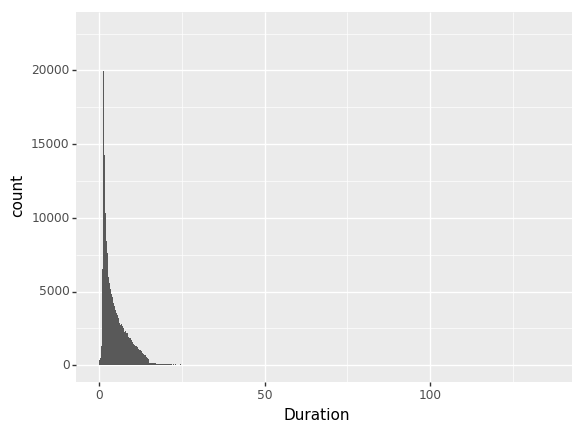

<ggplot: (-9223363249293320476)>

/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/stats/stat_bin.py:93: UserWarning: 'stat_bin()' using 'bins = 148'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))
/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/layer.py:360: UserWarning: stat_bin : Removed 4049 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/layer.py:449: UserWarning: geom_histogram : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


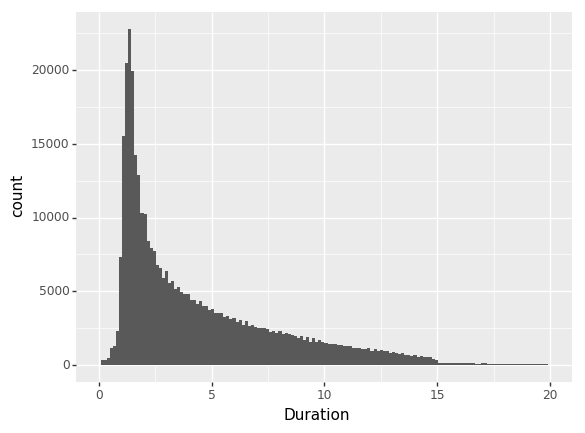

<ggplot: (8787562617436)>

In [249]:
ggplot(durations_df, aes(x="Duration")) + geom_histogram()
ggplot(durations_df, aes(x="Duration")) + geom_histogram() + xlim(0.0, 20.0)

/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/stats/stat_bin.py:93: UserWarning: 'stat_bin()' using 'bins = 267'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))


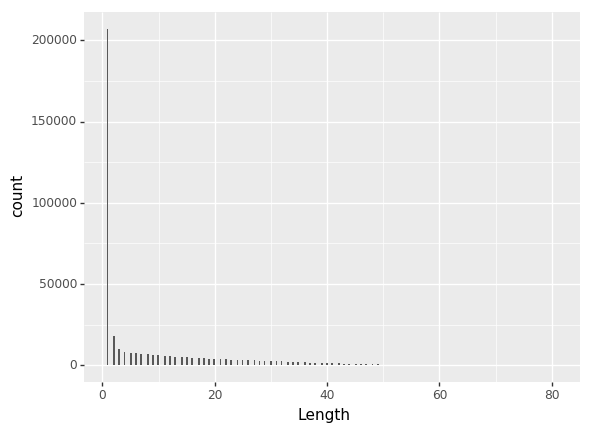

<ggplot: (-9223363249292960694)>

/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/stats/stat_bin.py:93: UserWarning: 'stat_bin()' using 'bins = 163'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))
/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/layer.py:360: UserWarning: stat_bin : Removed 2079 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/layer.py:449: UserWarning: geom_histogram : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


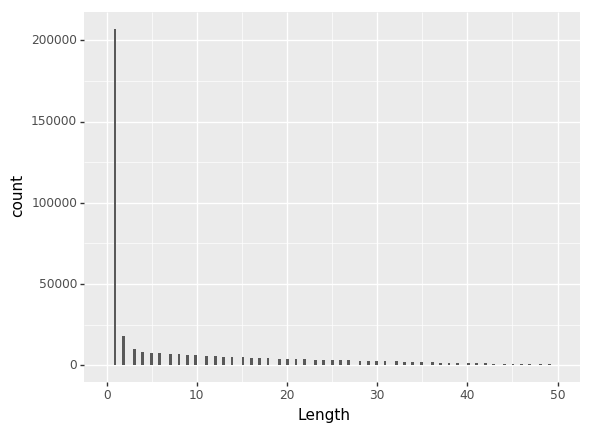

<ggplot: (8787561879837)>

In [247]:
ggplot(lengths_df, aes(x="Length")) + geom_histogram()
ggplot(lengths_df, aes(x="Length")) + geom_histogram() + xlim(0.0, 50.0)

/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/stats/stat_bin.py:93: UserWarning: 'stat_bin()' using 'bins = 549'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))


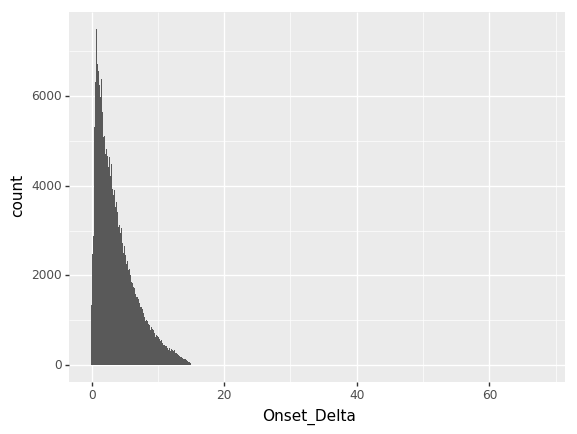

<ggplot: (8787562938011)>

/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/stats/stat_bin.py:93: UserWarning: 'stat_bin()' using 'bins = 161'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))
/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/layer.py:360: UserWarning: stat_bin : Removed 17 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/layer.py:449: UserWarning: geom_histogram : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


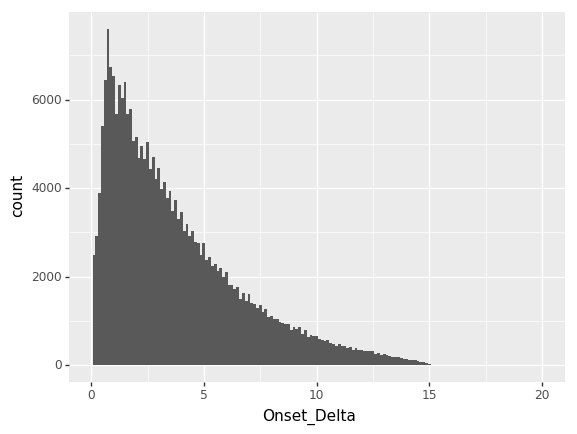

<ggplot: (-9223363249291010472)>

In [250]:
ggplot(onset_deltas_df, aes(x="Onset_Delta")) + geom_histogram()
ggplot(onset_deltas_df, aes(x="Onset_Delta")) + geom_histogram() + xlim(0.0, 20.0)

# NXT Switchboard

## Context

The NXT Switchboard corpus has an enormous amount of annotation on it. See
 - http://groups.inf.ed.ac.uk/switchboard/structure.html
 - http://groups.inf.ed.ac.uk/switchboard/datasum.html
 - http://groups.inf.ed.ac.uk/switchboard/coverage.html
 - .../switchboard_NXT_annotations/nxt_switchboard_ann/xml/swbd-metadata.xml

for more on the structure of the annotations.

We want (minimally, at this point) to relate
 - each `conversation id` in the corpus
 - with the set of `turn`s by each `speaker` in the associated conversation

We also want to associate 
 - each `turn` 
 - with `start`/`stop` times and a sequence of `phonword`s.

and
 - each `phonword`
 - with `start`/`stop` times and a sequence of `phones`
 
and
 - each `phone`
 - with `start`/`stop` times

In [101]:
nxt_dir = "/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann"

In [113]:
os.chdir(nxt_dir)
os.listdir()

['docs',
 'lib',
 'xml',
 'index.html',
 'nxt_1.4.3.tgz',
 'switchboard-guis.bat',
 'switchboard-guis.sh']

In [114]:
os.chdir('xml')
os.listdir()

['accent',
 'active',
 'breaks',
 'coreference',
 'corpus-resources',
 'dialAct',
 'disfluency',
 'kontrast',
 'markable',
 'movement',
 'phones',
 'phonwords',
 'phrase',
 'prosnotes',
 'syllables',
 'syntax',
 'terminals',
 'turns',
 'swbd-metadata.xml',
 'swconfig.xml']

In [219]:
def extract_conversation_IDs_from_filename(fn):
    return fn[2:6]

def conversations_covered_in_fp(fp):
    return set(map(extract_conversation_IDs_from_filename,
                   os.listdir(fp)))

def getFileInfo(conversation_id, speaker, annotation, justFileName=True):
    assert speaker in {'A', 'B'}, 'Speaker must be either "A" or "B", got {0}'.format(speaker)
    assert annotation in {'turns', 'phonwords', 'phones', 'syllables', 'syntax', 'terminals'}, "Annotation must be one of 'turns', 'phonwords', 'phones', or 'syllables', got {0}".format(annotation)
    
    annotation_dir = nxt_dir + '/xml/' + annotation
    covered_conversations = conversations_covered_in_fp(annotation_dir)
    assert conversation_id in covered_conversations, 'Conversation id {0} does not have annotations for {1}'.format(conversation_id, annotation)
    
    fn = 'sw' + conversation_id + '.' + speaker + '.' + annotation + '.xml'
    
    info = (annotation_dir, fn)
    assert os.path.isfile(os.path.join(*info)), 'Filename\n\t{0}\n does not exist in\n\t{1}'.format(fn, annotation_dir)
    
    if justFileName:
        return fn
    return annotation_dir, fn

In [148]:
getFileInfo('2079', 'B', 'turns')
# getFileInfo('2001', 'A', 'kontrast')
# os.path.join(*getFileInfo('2079', 'B', 'turns'))
# os.path.isfile( os.path.join(*getFileInfo('2079', 'B', 'turns')) )

'sw2079.B.turns.xml'

In [189]:
import xml.etree.ElementTree as ET

## Turns

In [191]:
turn_dir = os.path.join(nxt_dir, 'xml' + '/' + 'turns')
os.chdir(turn_dir)
os.listdir()

['sw2079.B.turns.xml',
 'sw2005.A.turns.xml',
 'sw2079.A.turns.xml',
 'sw2005.B.turns.xml',
 'sw2095.A.turns.xml',
 'sw2008.A.turns.xml',
 'sw2095.B.turns.xml',
 'sw2008.B.turns.xml',
 'sw2102.A.turns.xml',
 'sw2010.A.turns.xml',
 'sw2102.B.turns.xml',
 'sw2010.B.turns.xml',
 'sw2104.A.turns.xml',
 'sw2012.A.turns.xml',
 'sw2104.B.turns.xml',
 'sw2012.B.turns.xml',
 'sw2105.A.turns.xml',
 'sw2015.A.turns.xml',
 'sw2105.B.turns.xml',
 'sw2015.B.turns.xml',
 'sw2107.A.turns.xml',
 'sw2018.A.turns.xml',
 'sw2107.B.turns.xml',
 'sw2018.B.turns.xml',
 'sw2109.A.turns.xml',
 'sw2020.A.turns.xml',
 'sw2109.B.turns.xml',
 'sw2020.B.turns.xml',
 'sw2111.A.turns.xml',
 'sw2022.A.turns.xml',
 'sw2111.B.turns.xml',
 'sw2022.B.turns.xml',
 'sw2113.A.turns.xml',
 'sw2024.A.turns.xml',
 'sw2113.B.turns.xml',
 'sw2024.B.turns.xml',
 'sw2120.A.turns.xml',
 'sw2027.A.turns.xml',
 'sw2120.B.turns.xml',
 'sw2027.B.turns.xml',
 'sw2121.A.turns.xml',
 'sw2028.A.turns.xml',
 'sw2121.B.turns.xml',
 'sw2028.B.

limit_output extension: Maximum message size of 20000 exceeded with 23005 characters

In [118]:
conversations_with_turns = conversations_covered_in_fp(turn_dir)
len(conversations_with_turns)

642

In [149]:
sorted(list(conversations_with_turns))[:10]

['2005',
 '2008',
 '2010',
 '2012',
 '2015',
 '2018',
 '2020',
 '2022',
 '2024',
 '2027']

In [194]:
getFileInfo('2005','A','turns')
sw2005a_turns = ET.parse(getFileInfo('2005','A','turns'))
r = sw2005a_turns.getroot()

'sw2005.A.turns.xml'

In [204]:
r.keys()
r.attrib
r.tag
turns = r.getchildren()
t0 = turns[0]
t0.attrib
t0.tag

['{http://nite.sourceforge.net/}id']

{'{http://nite.sourceforge.net/}id': 'sw2005-A-turns'}

'{http://nite.sourceforge.net/}turn_stream'

{'{http://nite.sourceforge.net/}id': 't1',
 '{http://nite.sourceforge.net/}start': '0.8',
 '{http://nite.sourceforge.net/}end': '10.85',
 'approx': 'false'}

'turn'

In [215]:
t0.attrib['{http://nite.sourceforge.net/}id']

't1'

In [212]:
c = t0.getchildren()[0]
c.attrib
c.tag

{'href': 'sw2005.A.syntax.xml#id(s1)..id(s2)'}

'{http://nite.sourceforge.net/}child'

In [218]:
'sw2005.A.syntax.xml#id(s1)..id(s2)'[:19]
'sw2005.A.syntax.xml#id(s1)..id(s2)'[20:].split('..')

'sw2005.A.syntax.xml'

['id(s1)', 'id(s2)']

In [230]:
nxt_dir + '/nxt/syntax'

'/mnt/truffle/corpora/switchboard_NXT_annotations/nxt_switchboard_ann/nxt/syntax'

In [229]:
sw2005a_syntax = ET.parse(os.path.join(*getFileInfo('2005','A','syntax', False)))
r_syn = sw2005a_syntax.getroot()
r_syn.keys()
r_syn.attrib
r_syn.tag
r_syn.getchildren()
r_syn_c0 = r_syn.getchildren()[0]
r_syn_c0.keys()
r_syn_c0.attrib
r_syn_c0.tag
r_syn_c0.getchildren()

['{http://nite.sourceforge.net/}id']

{'{http://nite.sourceforge.net/}id': 'sw2005-syntax-A'}

'{http://nite.sourceforge.net/}parse_stream'

[<Element 'parse' at 0x7fe04acf06d8>,
 <Element 'parse' at 0x7fe03a6c3e58>,
 <Element 'parse' at 0x7fe03a587868>,
 <Element 'parse' at 0x7fe03a587b88>,
 <Element 'parse' at 0x7fe03a587e08>,
 <Element 'parse' at 0x7fe03a587f98>,
 <Element 'parse' at 0x7fe03a504098>,
 <Element 'parse' at 0x7fe03a5041d8>,
 <Element 'parse' at 0x7fe03a504318>,
 <Element 'parse' at 0x7fe03a504408>,
 <Element 'parse' at 0x7fe03a504548>,
 <Element 'parse' at 0x7fe03a504818>,
 <Element 'parse' at 0x7fe03a504868>,
 <Element 'parse' at 0x7fe03a5049a8>,
 <Element 'parse' at 0x7fe03a48f688>,
 <Element 'parse' at 0x7fe03a30b318>,
 <Element 'parse' at 0x7fe03a30b818>,
 <Element 'parse' at 0x7fe03a267138>,
 <Element 'parse' at 0x7fe03a2679f8>,
 <Element 'parse' at 0x7fe03a267e08>,
 <Element 'parse' at 0x7fe03a1fe458>,
 <Element 'parse' at 0x7fe03a17e0e8>,
 <Element 'parse' at 0x7fe03a17eb38>,
 <Element 'parse' at 0x7fe03a0f56d8>,
 <Element 'parse' at 0x7fe03a001368>,
 <Element 'parse' at 0x7fe03a001ae8>,
 <Element 'p

['{http://nite.sourceforge.net/}id']

{'{http://nite.sourceforge.net/}id': 's1'}

'parse'

[<Element 'nt' at 0x7fe03a6c3cc8>]

In [ ]:
def turn_node_to_turn_rel(turn_node):
    n = turn_node
    n_id = n.attrib['{http://nite.sourceforge.net/}id']
    n_start = float(n.attrib['{http://nite.sourceforge.net/}start'])
    n_end = float(n.attrib['{http://nite.sourceforge.net/}end'])
    
    syn_s = n.getchildren()[0].attrib['href']
    syn_file = syn_s[:19]
    syn_start_id, syn_end_id = tuple(syn_s[20:].split('..'))
    syn_xml_fp = nxt_dir + '/nxt/syntax/' + syn_file
    syn_xml = ET.parse(syn_xml_fp)
    syn_xml_root = syn_xml.getroot()
    syn_seq = 
    
    rel = {'id':n_id,
           'start':n_start,
           'end':n_end,
           'duration':n_end - n_start}
    return rel

def turnfile_to_turn_seq(turn_fp):
    xml = ET.parse(turn_fp)
    r = xml.getroot()
    turns = r.getchildren()
    

## Phonwords

In [124]:
phonwords_dir = nxt_dir + '/xml/phonwords'

In [125]:
os.chdir(phonwords_dir)

In [127]:
conversations_with_phonwords = conversations_covered_in_fp(phonwords_dir)
len(conversations_with_phonwords)

642

## Phones

In [128]:
phones_dir = nxt_dir + '/xml/phones'

In [129]:
os.chdir(phones_dir)

In [130]:
conversations_with_phones = conversations_covered_in_fp(phones_dir)
len(conversations_with_phones)

642